# The Tree-Grid method & application to HJB equations in option pricing -code for whole time-space domain solution 

- This code can be downloaded from Jupyter as .py code. Line " #!/usr/bin/env python3 "  has to be added to the begining of the file.
- Implementation of 1D Tree-Grid method with boundary conditions possibly dependent on both t (time) and x (space). Problem coefficient have to be time-independent.

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

## Tree-Grid  method implementation

- The main function (Tree-Grid method with time-independent coefficients):

In [2]:
def TreeGridFull(X,T, model, TCBC):
    # INPUT: X -sorted state-space, T -sorted time-axis, model -object including functions for drift, volatility,
    # reward, and discount, TCBC -object including functions for terminal and boundary conditions
    # feasible BCs: dependent on both x (space) and t (time)
    # (this implementation is (up to more feasible BCs) equivalent to my matlab-function treegrid4_artdif_hjb(S,T,obj) )
    M=T.shape[0]
    N=X.shape[0]
    Controls=model.controls
    QN=Controls.shape[0]
    ext=model.extrem
    dt=T[1]-T[0]
    # reserving place for computed transition probabilities, transition indices and states after transition:
    [PV_left, PV_o, PV_right,  PbeyondBC_left, PbeyondBC_right,\
     index_left, index_o, index_right, X_left, X_o, X_right, Discount]\
    =[[0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN]
    # computing transition probabilites, indices and states for all possible controls:
    for k in range(QN):
        [PV_left[k], PV_o[k], PV_right[k], PbeyondBC_left[k], PbeyondBC_right[k],index_left[k],\
         index_o[k], index_right[k], X_left[k], X_o[k], X_right[k]]=approximate_flow(X,dt,Controls[k],model)
        Discount[k]=1-dt*model.discount(X,Controls[k])
    # creating "probability-vectors" for adding boundary conditions to boundary nodes:
    PBC_left=np.zeros(N)
    PBC_left[0]=1
    PBC_right=np.zeros(N)
    PBC_right[N-1]=1
    # reserving place for solution:
    VV=np.zeros([M,N])
    # starting with terminal condition:
    VV[0,:]=TCBC.TC(X)
    # reserving place for new-time-layer-candidates:
    W=np.zeros([QN,N])
    # consecutively computing V in all time layers: 
    for t in range(M-1):
        # computing new time-layer candidate for all possible controls:
        for k in range(QN):
            # 1. row:flows from inner nodes to inner or boundary nodes
            # 2. row: flows from inner nodes beyond the boundaries 
            # 3. row values at the boundary (first and last) nodes
            W[k]=Discount[k]*(PV_left[k]*VV[t,index_left[k]]+PV_o[k]*VV[t,index_o[k]]+PV_right[k]*VV[t,index_right[k]])\
            +PbeyondBC_left[k]*TCBC.BCL(X,T[M-1-t])+PbeyondBC_right[k]*TCBC.BCR(X,T[M-1-t])\
            +PBC_left*TCBC.BCL(X[0],T[M-2-t])+PBC_right*TCBC.BCR(X[N-1],T[M-2-t])
        # choosing (elementwise) maximum/minimum from candidates => constructing V in new time layer:
        if ext=='min':
            VV[t+1,:]=np.amin(W, axis=0)
        else:
            VV[t+1,:]=np.amax(W,axis=0) 
    # returning solution VV in the last (here initial) time layer:
    return VV

- the approximate flow function, for computing (mainly) the transition probabilities for each state:

In [3]:
def approximate_flow(X,dt,q,model):
    # INPUT: X -sorted state-space, dt -current time-step, q -current control, 
    # model-object including functions for drift, volatility, reward, and discount
    N=X.shape[0]
    X_inner=X[1:N-1]
    dx=np.max(X[1:N]-X[0:N-1])
    # computing volatility, drift and variance, expected value of new state-old state:
    vol=model.volatility(X_inner,q)
    drf=model.drift(X_inner,q)
    artVar=0.25*(abs(drf)*dt+np.sqrt((abs(drf)*dt)**2+4*dx*dt*abs(drf)))**2-(abs(drf)*dt)**2
    Var=np.maximum(vol**2*dt,artVar)
    E=drf*dt
    # computing exact left and right flow from each non-boundary (inner) state:
    X_inner_left_flow=X_inner-np.sqrt((dt*drf)**2+Var)
    X_inner_right_flow=X_inner+np.sqrt((dt*drf)**2+Var)
    # searching indices of the nearest left grid-point  to left flow and nearest right grid point to right flow:
    # (specially treated are cells with zero flow, to not divide by zero later when computing trans. probabilities)
    # (if the left flow lands beyond left boundary index=-1, if right lands beyond right boundary index=N)
    index_inner_left=np.searchsorted(X,X_inner_left_flow,side='right') -1 - (X_inner_left_flow==X_inner)
    index_inner_right=np.searchsorted(X,X_inner_right_flow,side='left') + (X_inner_right_flow==X_inner)
    
    # computing states from X-grid corresponding to left and right flow indices: 
    # (special treatment needed for unvalid indices -1, N; here state corresponds to exact flow, not to some grid state)
    X_inner_left=X[np.maximum(index_inner_left,0)]
    X_inner_left[index_inner_left==-1]=X_inner_left_flow[index_inner_left==-1]
    X_inner_right=X[np.minimum(index_inner_right,N-1)]
    X_inner_right[index_inner_right==N]=X_inner_right_flow[index_inner_right==N]
    # computing Deltas -distances between left/right state and initial (or middle) state:
    Delta_right_X=X_inner_right-X_inner
    Delta_left_X=X_inner-X_inner_left
    # computing transition probabilities for non-boundary (inner) states:
    P_inner_left=(-E*(Delta_right_X-E)+Var)/(Delta_left_X*(Delta_left_X+Delta_right_X))
    P_inner_o=((Delta_right_X-E)*(-Delta_left_X-E)+Var)/(-Delta_left_X*Delta_right_X)
    P_inner_right=(-E*(-Delta_left_X-E)+Var)/(Delta_right_X*(Delta_left_X+Delta_right_X))
    # extracting probabilites of transition to grid states (boundary states included),
    # if the transition is beyond the boundary for some state, probability=0:
    # (note: firstand last, (boundary) nodes are treated like being beyond the boundary)
    PV_left=np.concatenate([[0],P_inner_left*(index_inner_left!=-1),[0]])
    PV_o=np.concatenate([[0],P_inner_o,[0]])
    PV_right=np.concatenate([[0],P_inner_right*(index_inner_left!=N),[0]])
    # extracting probabilites of transition beyond left/right boundary (boundary states not included),
    # if the transition is to a grid state for some state, probability=0:
    PbeyondBC_left=np.concatenate([[0],P_inner_left*(index_inner_left==-1),[0]])
    PbeyondBC_right=np.concatenate([[0],P_inner_right*(index_inner_left==N),[0]])
    # rewriting unvalid indices (-1,N) by (0,N-1) to avoid out-of-scope-error:
    # (zero PV-probabilites for the states with indices (-1,N) will take care that
    # these states are not used as grid-states anyway)
    index_left=np.concatenate([[1],np.maximum(index_inner_left,0),[N-1]])
    index_o=np.concatenate([[1],np.arange(1,N-1),[N-1]])
    index_right=np.concatenate([[1],np.minimum(index_inner_right,N-1),[N-1]])
    # collecting all left, right, middle states for the case that BC's are state dependent:
    # (the grid-states are for this purpose redundant but doesn't matter.)
    X_left=np.concatenate([[X[0]],X_inner_left,[X[N-1]]])
    X_o=X
    X_right=np.concatenate([[X[0]],X_inner_right,[X[N-1]]])
    #returning transition probabilities, (for grid-states and beyond-boundary states separatelly) indices and states:
    return (PV_left,PV_o,PV_right,PbeyondBC_left,PbeyondBC_right,index_left,index_o,index_right,X_left,X_o,X_right)

## Application to uncertain volatility model

- Class defining drift, volatility reward and discount functions for the model (SCP=stochastic control problem):

In [4]:
class SCP_uncertain_volatility:
    extrem='max'
    controls=np.array([0.3, 0.45])
    interest=0.04
    def drift(self,x,q):
        return self.interest*x
    def volatility(self,x,q):
        return x*q
    def reward(self,x,q):
        return 0
    def discount(self,x,q):
        return self.interest

- Class defining the boundary conditions for the problem:

In [5]:
class TCBC_butterfly:
    def TC(self,X):
        V0=np.zeros(X.shape[0])
        for k in range(X.shape[0]):
            if X[k]<95:
                V0[k]=0
            elif X[k]>=95 and X[k]<100:
                V0[k]=X[k]-95
            elif X[k]<=105 and X[k]>=100:
                V0[k]=105-X[k]
            else:
                V0[k]=0
        return V0
    def BCL(self,x,t):
        return 0
    def BCR(self,x,t):
        return 0        

- solving the option pricing under uncertain volatility SCP with Tree-Grid method

In [6]:
# constructing non-equidistant state-space
X1=np.arange(0,500+20,20)
X2=np.arange(50,150+10,10)
X3=np.arange(80,120+1,1)
X4=np.arange(90,110+0.5,0.5)
X5a=np.arange(94,96+0.25,0.25)
X5b=np.arange(99,101+0.25,0.25)
X5=np.concatenate((np.arange(94,96+0.25,0.25),np.arange(99,101+0.25,0.25),np.arange(104,106+0.25,0.25)))
X = np.sort(np.unique(np.concatenate((X1,X2,X3,X4,X5))))
no_refinements=0
for k in range(no_refinements):
    XX=(X[1:X.shape[0]]+X[0:X.shape[0]-1])/2
    X=np.sort(np.unique(np.concatenate((X,XX))))
# time-axis
T=np.arange(0,0.5+0.005,0.005)
# objects for problem models:
maxmodel=SCP_uncertain_volatility()
minmodel=SCP_uncertain_volatility()
minmodel.extrem='min'
# object with terminal and boundary condition functions:
TCBC=TCBC_butterfly()
# solving the problem:
Vmax=TreeGridFull(X,T, maxmodel, TCBC)
Vmin=TreeGridFull(X,T, minmodel, TCBC)

- plotting initial conditions and solutions:

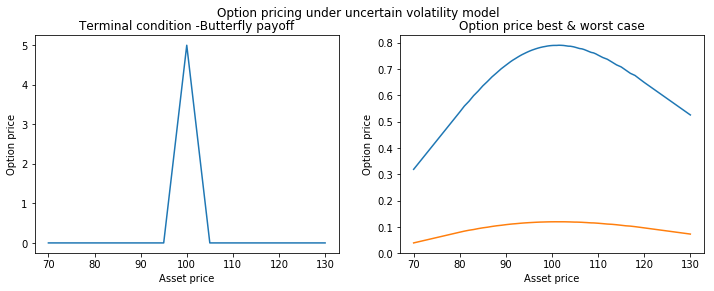

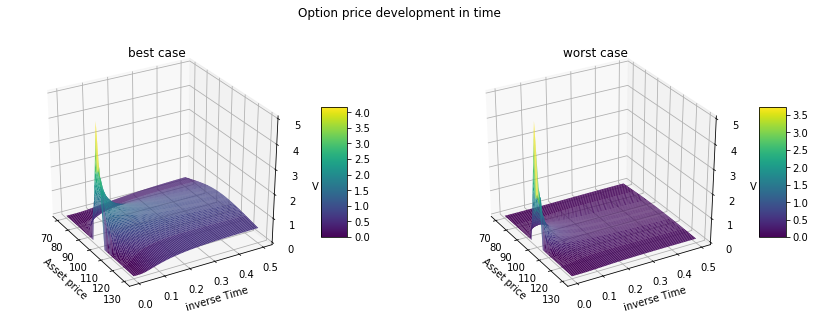

In [7]:
domain=np.logical_and(X>=70,X<=130)
fig = plt.figure()
fig.suptitle('Option pricing under uncertain volatility model',fontsize=12)
figsz=fig.get_size_inches() # returns size of figure
fig.set_size_inches(2*figsz[0],1*figsz[1]) 

pl0 = fig.add_subplot(121)
pl0.plot(X[domain],Vmin[0,domain])
pl0.set_title('Terminal condition -Butterfly payoff')
pl0.set_xlabel('Asset price')
pl0.set_ylabel('Option price')

pl0 = fig.add_subplot(122)
pl0.plot(X[domain],Vmax[-1,domain],X[domain],Vmin[-1,domain])
pl0.set_title('Option price best & worst case')
pl0.set_xlabel('Asset price')
pl0.set_ylabel('Option price')
plt.show()

#3D plotting

Xm, Tm = np.meshgrid(X[domain], T)
fig2 = plt.figure()
fig2.suptitle('Option price development in time',fontsize=12)
fig2sz=fig2.get_size_inches() # returns size of figure
fig2.set_size_inches(2.4*figsz[0],1.2*figsz[1])

pl1 = fig2.add_subplot(1,2,1,projection='3d')
surf = pl1.plot_surface(Xm, Tm, Vmax[:,domain], rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig2.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('Asset price')
pl1.set_ylabel('inverse Time')
pl1.set_zlabel('V')
pl1.set_title('best case')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=330)

pl1 = fig2.add_subplot(1,2,2,projection='3d')
surf = pl1.plot_surface(Xm, Tm, Vmin[:,domain], rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig2.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('Asset price')
pl1.set_ylabel('inverse Time')
pl1.set_zlabel('V')
pl1.set_title('worst case')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=330)
plt.show()

## Application to passport option pricing model

- Class defining drift, volatility reward and discount functions for the model (SCP=stochastic control problem):

In [8]:
class SCP_passport:
    extrem='max'
    controls=np.arange(-1,1+0.5,0.5)
    r=0.08
    rt=0.05
    rc=0.12
    gama=0.03
    sig=0.2
    
    def drift(self,x,q):
        return (self.r-self.rc-self.gama)*q+(self.r-self.rt-self.gama)*x
    def volatility(self,x,q):
        return self.sig*(abs(x-q))
    def reward(self,x,q):
        return 0
    def discount(self,x,q):
        return self.gama

- Classes defining the boundary conditions for the problem:

In [9]:
class TCBC_capped:
    def TC(self,X):
        V0=np.zeros(X.shape[0])
        for k in range(X.shape[0]):
            if X[k]<0:
                V0[k]=0
            elif X[k]>=0 and X[k]<1:
                V0[k]=X[k]
            else:
                V0[k]=1
        return V0
    def BCL(self,x,t):
        return 0
    def BCR(self,x,t):
        return 1 

In [10]:
class TCBC_binary:
    def TC(self,X):
        V0=np.zeros(X.shape[0])
        for k in range(X.shape[0]):
            if X[k]<0:
                V0[k]=0
            else:
                V0[k]=1
        return V0
    def BCL(self,x,t):
        return 0
    def BCR(self,x,t):
        return 1 

- solving the Passport option pricing SCP with Tree-Grid method

In [11]:
# constructing non-equidistant state-space:
X1=np.arange(-3,4+1,1)
X2=np.arange(-1.5,1.5+0.5,0.5)
X3=np.arange(-1,1+0.25,0.25)
X4=np.arange(-0.5,0.5+0.125,0.125)
X5=np.arange(-0.25,0.25+0.0625,0.0625)
X = np.sort(np.unique(np.concatenate((X1,X2,X3,X4,X5))))
#refining the state-space by adding a new state between each 2 neighbouring states:
no_refinements=2
for k in range(no_refinements):
    XX=(X[1:X.shape[0]]+X[0:X.shape[0]-1])/2
    X=np.sort(np.unique(np.concatenate((X,XX))))
# time-axis
T=np.arange(0,0.5+0.01,0.01)
# object for problem model:
model=SCP_passport()
# objects with terminal and boundary condition functions:
binTCBC=TCBC_binary()
capTCBC=TCBC_capped()
# solving the problem:
Vbin=TreeGridFull(X,T, model, binTCBC)
Vcap=TreeGridFull(X,T, model, capTCBC)

- plotting initial conditions and solutions:

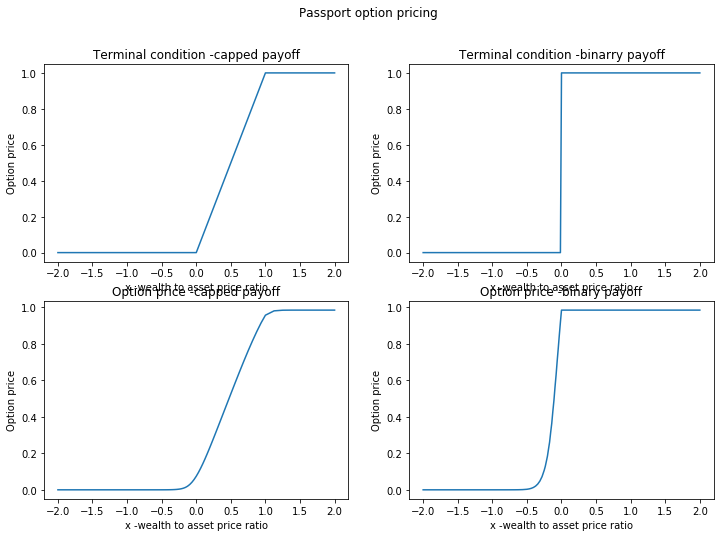

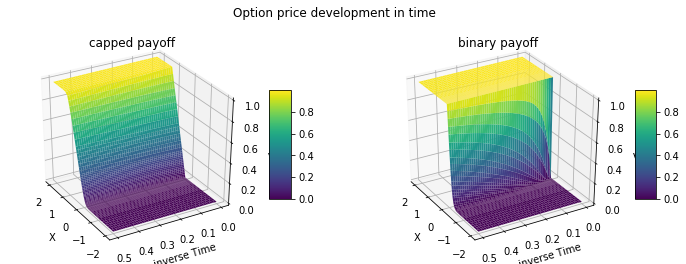

In [12]:
domain=np.logical_and(X>=-2,X<=2)
fig = plt.figure()
fig.suptitle('Passport option pricing',fontsize=12)
figsz=fig.get_size_inches() # returns size of figure
fig.set_size_inches(2*figsz[0],2*figsz[1]) 

pl0 = fig.add_subplot(221)
pl0.plot(X[domain],capTCBC.TC(X)[domain])
pl0.set_title('Terminal condition -capped payoff')
pl0.set_xlabel('x -wealth to asset price ratio')
pl0.set_ylabel('Option price')

pl0 = fig.add_subplot(222)
pl0.plot(X[domain],binTCBC.TC(X)[domain])
pl0.set_title('Terminal condition -binarry payoff')
pl0.set_xlabel('x -wealth to asset price ratio')
pl0.set_ylabel('Option price')

pl0 = fig.add_subplot(223)
pl0.plot(X[domain],Vcap[-1,domain])
pl0.set_title('Option price -capped payoff')
pl0.set_xlabel('x -wealth to asset price ratio')
pl0.set_ylabel('Option price')

pl0 = fig.add_subplot(224)
pl0.plot(X[domain],Vbin[-1,domain])
pl0.set_title('Option price -binary payoff')
pl0.set_xlabel('x -wealth to asset price ratio')
pl0.set_ylabel('Option price')
plt.show()

Xm, Tm = np.meshgrid(X[domain], T)
fig2 = plt.figure()
fig2.suptitle('Option price development in time',fontsize=12)
fig2sz=fig2.get_size_inches() # returns size of figure
fig2.set_size_inches(2*figsz[0],1*figsz[1])

pl1 = fig2.add_subplot(1,2,1,projection='3d')
surf = pl1.plot_surface(Xm, Tm, Vcap[:,domain], rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig2.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('X')
pl1.set_ylabel('inverse Time')
pl1.set_zlabel('V')
pl1.set_title('capped payoff')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=150)

pl1 = fig2.add_subplot(1,2,2,projection='3d')
surf = pl1.plot_surface(Xm, Tm, Vbin[:,domain], rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig2.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('X')
pl1.set_ylabel('inverse Time')
pl1.set_zlabel('V')
pl1.set_title('binary payoff')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=150)
plt.show()